In [1]:
import matplotlib

%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import time
from rr_python_sdk import cpp, MeasurementHead

# Make head object (and handshake)

In [2]:
head = MeasurementHead()

USB Serial Port (COM8) 1027
Auto detected: USB Serial Port (COM8)
Handshake acknowledged: <rr_python_sdk.mh_protocol_py.HandshakeToHostPayload object at 0x000001A936DB70B0>


In [3]:
head.restart()

## Optionally, rehandshake
Eg if device disconnects without serial diconenction from the usb bridge board, or if device restarts

In [4]:
head.shakehands()

Handshake acknowledged: <rr_python_sdk.mh_protocol_py.HandshakeToHostPayload object at 0x000001A936EDAAF0>


True

# Home and tare forces
Home the actuator, and tare the forces (needed before sensible force data can be collected)

In [5]:
head.home()

In [6]:
head.zero_forces()

# Read single or all mesages from the device

In [7]:
def print_simple_message(msg):
    if msg.type == cpp.MsgType_ToHost.ACK:
        print(f"Head acknowlages message: {msg.data.msg_type}")
    elif msg.type == cpp.MsgType_ToHost.ERR:
        print(f"Head negative acknowlages message: {msg.data.reason}")
    elif msg.type == cpp.MsgType_ToHost.NewFault:
        print(f"Instruction caused fault, fault must be cleared before operation {msg.data.reason}")
    elif msg.type != cpp.MsgType_ToHost.NoMessage:
        print(f"Message type: {msg.type}, Msg data: {msg.data}")
    else:
        print("No message recieved")
        return None
    return msg.data

In [8]:
msg = head.read()
data = print_simple_message(msg)

Head acknowlages message: MsgType_ToDevice.Home


In [9]:
msgs = head.read_all(timeout=0.1)
for msg in msgs:
    print_simple_message(msg)

Head acknowlages message: MsgType_ToDevice.ZeroForces


# Check or clear fault status
If some physical problem is encountered (eg: limit switch hit while active, move out of range, over load etc.) The head will generate a NewFault message and stop what it is doing. This fault indicates some physical problem with the device, it needs to be cleared before the device will function again. 

The fault status can be inspected with request fault data, only a 0 status code means no fault is present.

In [10]:
head.read_all(timeout = 0) # flush any waiting messages

head.request_fault_data()
msg = head.read()
if msg.type == cpp.MsgType_ToHost.FaultStatusData:
    print(f"Status code: {msg.data.fault_status}")

Status code: 0


The meaning of the fault and fault status codes can be found [here](https://github.com/RivelinRail/MeasurmentHeadProtocol/blob/cedc6987c7599e11f22d9e4f27f2ea995850e13e/include/protocol/measurement_head_types.hpp). When generated as a new fault message the enum values will be sent, when present in the fault status, the corresponding bit of the status will be set.

For example a normal force overload will cause a new fault message of 5 to be sent and will update the fault status by setting the 5th bit to true.

The fault status of the device can be cleared by sending a clear_fault message as shown below. The status also resets when the device restarts.

In [11]:
if msg.type == cpp.MsgType_ToHost.FaultStatusData and msg.data.fault_status:
    head.clear_fault()
else:
    print("No fault to clear")

No fault to clear


# Requesting force data
Force data can be requested either one point at a time or continuously streamed the two cells below show examples of each.

With the force data comes details fo the current status of the device, including calibration status fo the load cells. This status is a bit field, the meanings of each bit can be found [here](https://github.com/RivelinRail/MeasurmentHeadProtocol/blob/cedc6987c7599e11f22d9e4f27f2ea995850e13e/include/protocol/measurement_head_types.hpp).

In [12]:
head.read_all(timeout=0.1)
head.request_current_force_data()
msg = head.read()
if msg.type == cpp.MsgType_ToHost.CurrentData:
    print(f"Status: {int(msg.data.device_status):032b}\tFn: {msg.data.f_normal_mn/1000:.2f}\tFt: {msg.data.f_tangential_mn/1000:.2f}")

Status: 00000001000001011111000001000010	Fn: -0.29	Ft: 0.02


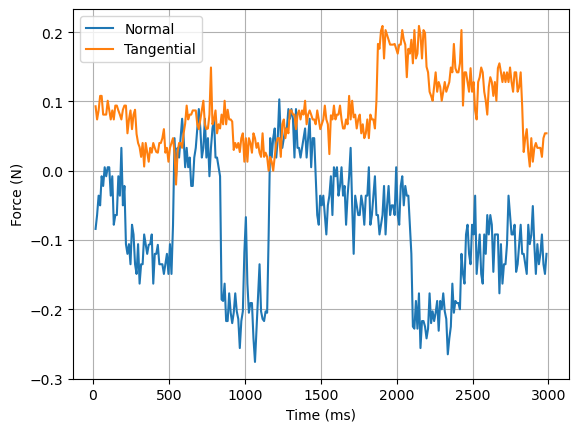

In [13]:
def plot_force_data(data_rate = 100, duration = 3, read_all = True):
    points = []
    if read_all:
        head.read_all(timeout = 0.1)
    pl = cpp.DataRatePayload()
    pl.rate_hz = data_rate
    head.start_data_streaming(pl)
    dur_int = 2*int(duration)
    to = 0.1
    for i in range(dur_int):
        time.sleep(duration/dur_int-to)
        points.extend([msg for msg in head.read_all(timeout = to) if msg.type==cpp.MsgType_ToHost.CurrentData])
    head.stop_data_streaming()
    
    points = points[1:] # when the loadcells are initialised at the same time as the data streaming started, the first result can be invalid
    
    x = np.array([p.data.millis_since_start for p in points])
    normal = np.array([p.data.f_normal_mn/1000 for p in points])
    tangential = np.array([p.data.f_tangential_mn/1000 for p in points])
    plt.plot(x, normal, label="Normal")
    plt.plot(x, tangential, label="Tangential")

    plt.xlabel("Time (ms)")
    plt.ylabel("Force (N)")
    
    plt.grid()
    plt.legend()
    plt.show()

    _ = head.read_all(timeout = 0.1) # it is possible to recieve an extra force data point here as well as the ack reply
    
    return points

points = plot_force_data()

# Setting and updating the normal force
The normal force can be set or updated while in contact as shown in the following 2 cells. To stop force control, you can simply tell the device to go home

In [14]:
payload = cpp.SetForcePayload()
payload.force_mn = 100000
head.start_force_control(payload)

In [15]:
# this cell has no effect if the head is not maintaining a force
payload = cpp.SetForcePayload()
payload.force_mn = 150000
head.update_set_force(payload)

In [16]:
head.home()

Alternativelyhead.abort_move() the head can be immediately stopped:

In [17]:
head.abort_move()

# Updating configuration
The device exposes many configuration options in a config struct, the simplest way to update these without invalidating the device config is to first read the config from the device, edit it and write it back to the device. The device will either acknowlage this or generate an error, and revert to the original config. The config cannot be updated when the device is maintaining a force or streaming data.

When the config is written to the device ram it will persist until the device is restarted. If you wish to save the new config so it persists indefinately, you must save the config to the device flash.

In [18]:
head.read_all(timeout = 0.1)
head.request_config()
msg = head.read()
if msg.type == cpp.MsgType_ToHost.ConfigData:
    msg.data.normal_lc.minimum_zero_offset = 130
    head.write_config(msg.data)
msg = head.read()
if msg.type == cpp.MsgType_ToHost.ACK and msg.data.msg_type == cpp.MsgType_ToDevice.WriteConfig:
    print("Config successfully updated (RAM only, will not persist)")

Config successfully updated (RAM only, will not persist)


In [19]:
head.write_config_to_flash()
msg = head.read()
if msg.type == cpp.MsgType_ToHost.ACK and msg.data.msg_type == cpp.MsgType_ToDevice.WriteConfigToFlash:
    print("Config updated on flash (will persist if device restarts)")

Config updated on flash (will persist if device restarts)


## Resetting the config
At any point the factory default config can be reloaded using reset_to_defaults. This immdeiately writes the default config to the flash and triggers a restart of the device.

This has no effect on the calibration of the load cells.

In [20]:
head.reset_to_defaults() 
time.sleep(2)
head.shakehands()

Handshake acknowledged: <rr_python_sdk.mh_protocol_py.HandshakeToHostPayload object at 0x000001A936B03270>


True

In [23]:
head.zero_forces()

## Tuning the pd controller
The PD controller in the device can be tuned while the device is maintaining a force. This may be necessary if you are runing the device on soft surfaces or at a force too low to activate the suspension.

The cell below indicates how this is done. Note that these changes are only to the RAM of the device, if you want tuning changes to persist the config must be written to the device flash as described above

The diferential of the device signal is calculated by decaying weight least squares, the diferential decay value controls this decay. It should be greater than 0 and less than 1. Some other parameters in this struct are place holders and have no effect: PID_I, max_deriv_control, max_integral_error.

In [24]:
payload = cpp.PidConfig()
payload.diferential_decay = 0.3
payload.n_settle = 20
payload.PID_P = 0.00015
payload.PID_D = 35
payload.settle_tollerance = 0.015
payload.touch_force_mn = 5000
head.update_pid_config(payload)

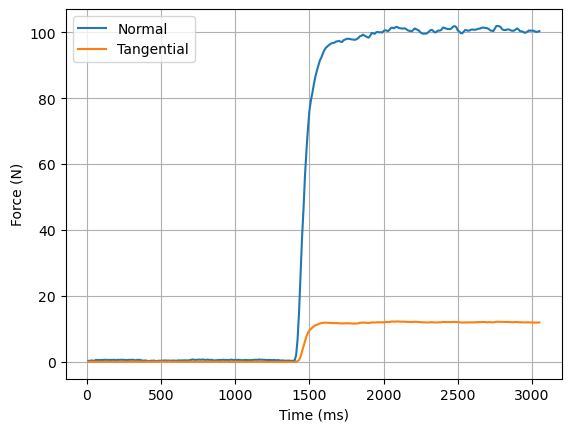

In [25]:
payload = cpp.SetForcePayload()
payload.force_mn = 100000
head.start_force_control(payload)
plot_force_data(100, 3)
head.home()

# Restarting the head
The head can be remotely restarted, you will need to complete the handshake when it has booted in order to communicate with it

In [26]:
head.restart()
time.sleep(2)
head.shakehands()

Handshake acknowledged: <rr_python_sdk.mh_protocol_py.HandshakeToHostPayload object at 0x000001A936F758F0>


True

# Jogging the motor
The normal axis of the head can be jogged, note that unless the head is streaming data the load cells will not be read duing this process and the motor will not stop if they are being over loaded.

In [27]:
payload = cpp.JogPayload()
payload.distance_mm = 1.0
head.jog_motor(payload)

# Orientation data
The head contains an accelerometer that can be used to measure the roll and incline of the device. These can tell you if the track you are on is inclined either up or down hill, or if the head is rolled from vertical (eg if you are measuring at the gauge face). Angles are in degrees.

In [28]:
head.read_all(timeout = 1)
head.request_orientation()
msg = head.read()
if msg.type == cpp.MsgType_ToHost.OrientationData:
    print(f"Incline: {msg.data.incline}\tRoll: {msg.data.roll}")

Incline: -1.0556131601333618	Roll: -0.28285181522369385
